In [1]:
import numpy as np
import functools
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from clustering_by_classification import ClusterByClassifier

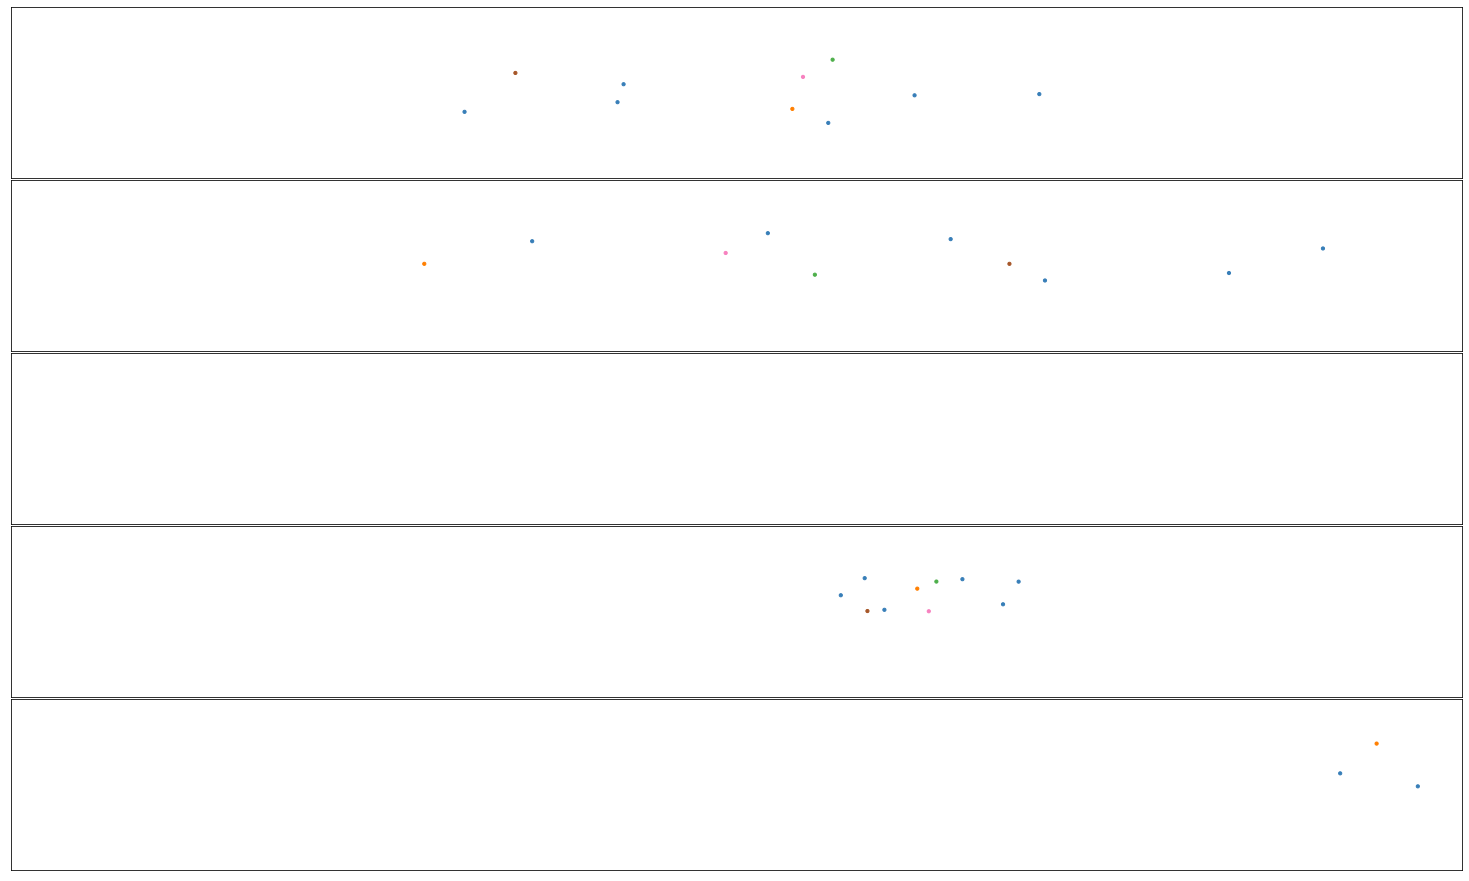

In [2]:
from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice
%matplotlib inline

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)


dataset_types = [
    noisy_circles,
    noisy_moons,
    blobs,
    no_structure,
    varied
]

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

for i, dataset in enumerate(dataset_types):
    X = dataset[0]
    cl = ClusterByClassifier(DecisionTreeClassifier(),
                             n_clusters=5,
                             max_iters=1000000,
                             soft_clustering=True)
    y_pred = cl.fit_predict(X)
    
    
    plt.subplot(len(dataset_types), 1, i+1)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                        int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

In [3]:
np.random.randint(5)

2

In [4]:
t = np.random.uniform(size=(5,3))

In [5]:
np.max(t, axis=1)

array([0.97552151, 0.72999056, 0.52103661, 0.7936977 , 0.92808129])

In [6]:
clf = LogisticRegression()
x = noisy_moons = datasets.make_moons(n_samples=10, noise=.05)[0]

y =	np.zeros(10)
first = np.random.randint(10)
seen = {first}

second = np.random.randint(10)
while second in seen:
    second = np.random.randint(10)
seen.add(second)
ct = 1
for label in seen:
    y[label] = ct
    ct = ct + 1

clf.fit(x,y)

probas = clf.predict_proba(x)

In [7]:
dists = np.max(1.0 - probas, axis=1)

In [8]:
np.random.choice(10, p=dists/np.sum(dists))

7